### Gradients, Convolution Kernels, & SVMs

<h5>This notebook is designed as a teaching guide</h5>

In [5]:
# Setting it up
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [6]:
np.random.seed(42)

### 1. Gradients Explainer

`We will explain what is Gradients, visualize them, directional derivatives, and the Hessian (Second Derivatives).`

In [7]:
# Scalar field Examples

def radial(x, y):
    return x ** 2 + y ** 2

In [8]:
def sinusodial(x, y):
    return np.sin(x) * np.cos(y)

In [9]:
# Grid formation
x = np.linspace(-3, 3, 40)
y = np.linspace(-3, 3, 40)
X, Y = np.meshgrid(x, y)

In [10]:
# compute gradients numerically for a field
def compute_gradients(f, X, Y, eps=1e-5):
    U = (f(X+eps, Y) - f(X-eps, Y)) / (2*eps)
    V = (f(X, Y+eps) - f(X, Y-eps)) / (2*eps)
    return U, V

U_r, V_r = compute_gradients(radial, X, Y)

**1.1 Gradients Field**

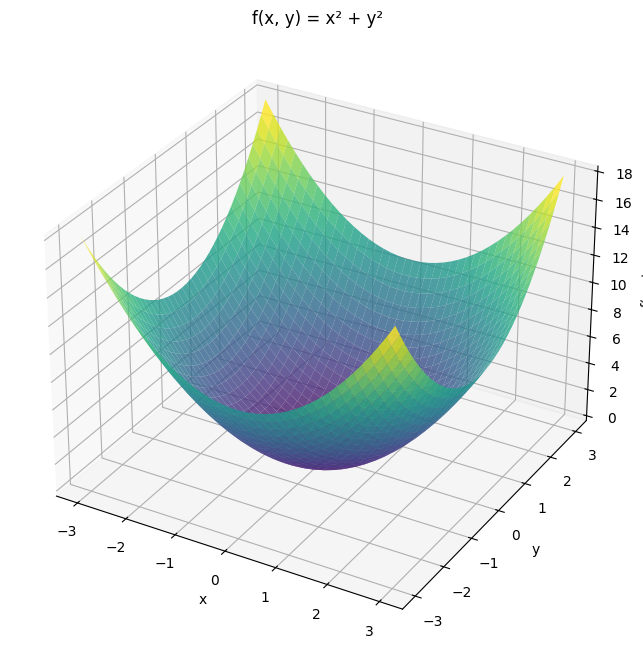

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

Z = X**2 + Y**2
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

ax.set_title('f(x, y) = x² + y²')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')
plt.show()

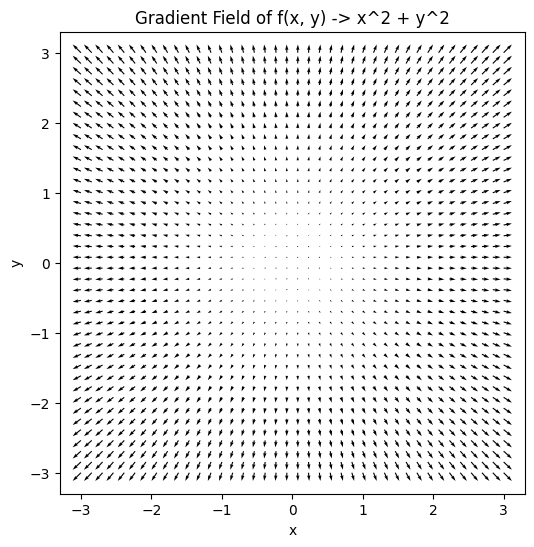

In [13]:
# In 2D
plt.figure(figsize=(6,6))
plt.quiver(X, Y, U_r, V_r, cmap="Blues")
plt.title('Gradient Field of f(x, y) -> x^2 + y^2')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

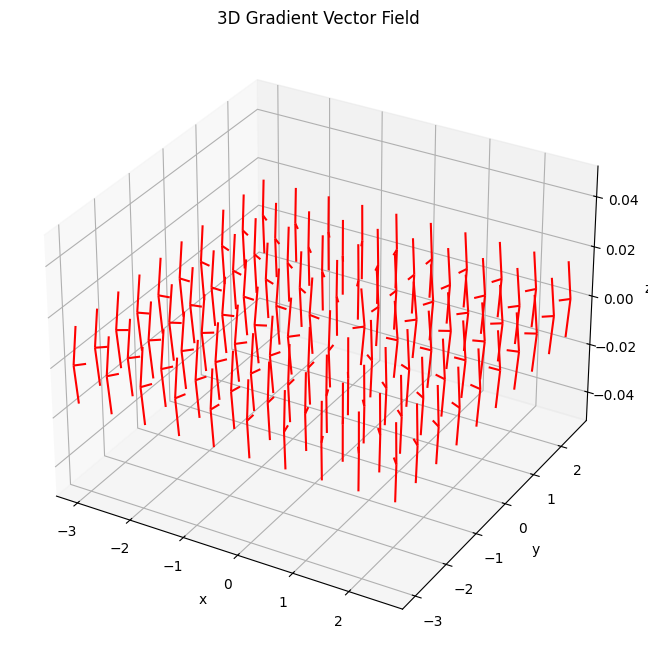

In [14]:
# In 3D 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Just the gradient vectors in 3D space
ax.quiver(X[::4,::4], Y[::4,::4], np.zeros_like(X[::4,::4]), 
          U_r[::4,::4], V_r[::4,::4], np.zeros_like(U_r[::4,::4]), 
          color='red', length=0.2, normalize=True)

ax.set_title('3D Gradient Vector Field')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.show()


**1.2 Gradient Flow**

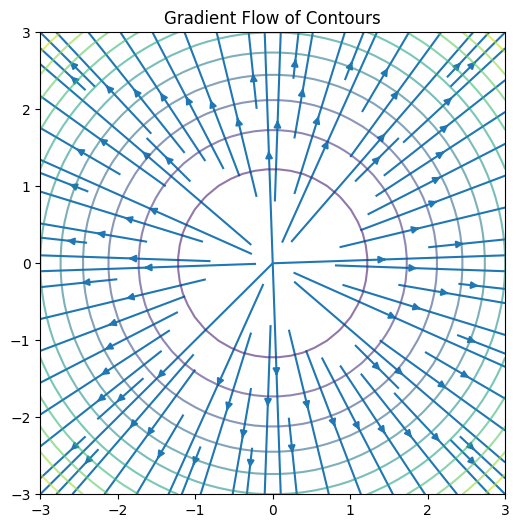

In [15]:
plt.figure(figsize=(6, 6))
plt.streamplot(X, Y, U_r, V_r)
plt.contour(X, Y, radial(X, Y), levels=12, alpha=0.6)
plt.title('Gradient Flow of Contours')
plt.show()

**Direction Derivative demonstration**

In [16]:
point = np.array([1.0, 0.5])
U_pt, V_pt =  compute_gradients(radial, point[0:1], point[1:2])
grad_pt = np.array([U_pt[0], V_pt[0]])
print('Gradients at', point, '->', grad_pt)

Gradients at [1.  0.5] -> [2. 1.]


**Directional Derivative along unit direction `U`**

In [17]:
u = np.array([1.0, 1.0])
u = u / np.linalg.norm(u)

# basically gradient alongside u: so grad * u
print('Directional derivative along u', u, ':', grad_pt.dot(u))

Directional derivative along u [0.70710678 0.70710678] : 2.121320343565689


### 2. Hessian: Second Derivatives and curvature
**Hessian provides local curvature information. we'll compute and visualize eigenvalues**

In [18]:
def compute_hessian(f, x0, y0, h=1e-4):
    f_xx = (f(x0+h, y0) - 2*f(x0, y0) + f(x0-h, y0)) / (h ** 2)
    f_yy = (f(x0,y0+h) - 2*f(x0,y0) + f(x0,y0-h)) / (h**2)
    f_xy = (f(x0+h,y0+h) - f(x0+h,y0-h) - f(x0-h,y0+h) + f(x0-h,y0-h)) / (4*h**2)
    return np.array([[f_xx, f_xy],[f_xy, f_yy]])

In [19]:
# takin sampling at several points for sinusoidal field
pts = [(-1, -1),
       (0, 0),
       (1, 2),
       (0.5, -0.5)]

for p in pts:
    H = compute_hessian(sinusodial, p[0], p[1])
    eigs = np.linalg.eigvals(H)
    print(f'Point {p} -> Hessian: {H} EigenValues: {eigs}')

Point (-1, -1) -> Hessian: [[0.45464871 0.45464871]
 [0.45464871 0.45464873]] EigenValues: [9.71445135e-09 9.09297433e-01]
Point (0, 0) -> Hessian: [[0. 0.]
 [0. 0.]] EigenValues: [0. 0.]
Point (1, 2) -> Hessian: [[ 0.35017548 -0.49129549]
 [-0.49129549  0.35017547]] EigenValues: [ 0.84147097 -0.14112002]
Point (0.5, -0.5) -> Hessian: [[-0.42073549  0.42073549]
 [ 0.42073549 -0.42073549]] EigenValues: [ 2.77555751e-09 -8.41470979e-01]


In [20]:
# visualize scaler field with a curvature shading: use determinant of Hessian Estimation
H_det = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        H = compute_hessian(sinusodial, X[i, j], Y[i, j])
        H_det[i, j] = np.linalg.det(H)

**In 2D structure**

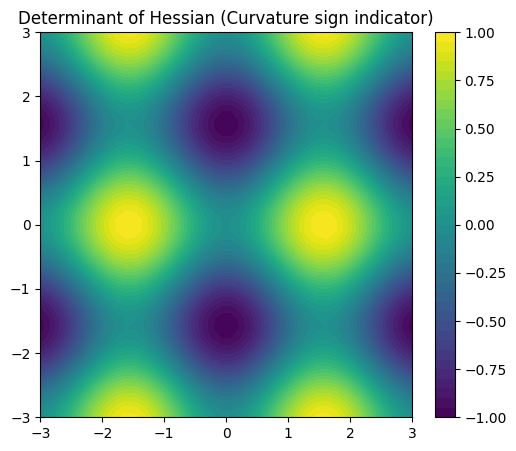

In [21]:
plt.figure(figsize=(6, 5))
cs = plt.contourf(X, Y, H_det, levels=40)
plt.colorbar(cs)
plt.title('Determinant of Hessian (Curvature sign indicator)')
plt.show()

**In 3D-Curvature**

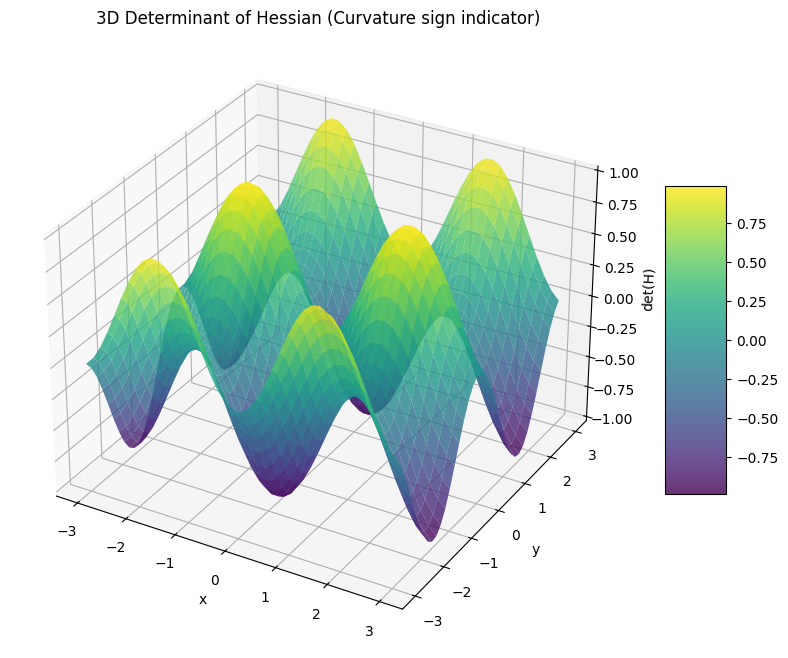

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, H_det, cmap='viridis', alpha=0.8)
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_title('3D Determinant of Hessian (Curvature sign indicator)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('det(H)')
plt.show()


### 2. More on Gradients: Fields in Physics and Geomentry
- **Gradients are perpendicular to level sets(contour)**
- **In physics, $force = -grad(potential)$. We'll visualize potentials and forces**

In [23]:
# Gassian well
def gaussian(x, y, sigma=1.0):
    return np.exp(-(x**2 + y ** 2) / (2 * sigma **2))

U_g, V_g = compute_gradients(gaussian, X, Y)

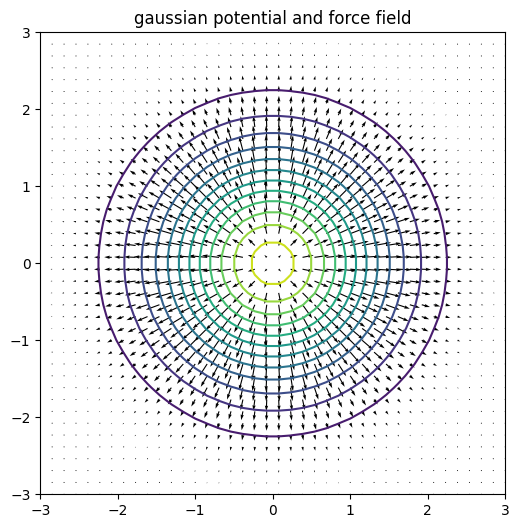

In [24]:
plt.figure(figsize=(6, 6))
plt.contour(X, Y, gaussian(X, Y), levels=12)
plt.quiver(X, Y, -U_g, -V_g)
plt.title('gaussian potential and force field')
plt.show()

### 3. Convolutions: Visually learned Vs Hand-designed filters

In [25]:
# creating a simplistic Image to solve a convolve problem

img = np.zeros((28, 28))
img[8:20, 10:18] = 1.0

filters = {
    'edge_laplace' : np.array([[-1, -1, -1], [-1, 8, -1], [-1, 8, -1]]),
    'sobel_x' : np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    'sobel_y' : np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
}

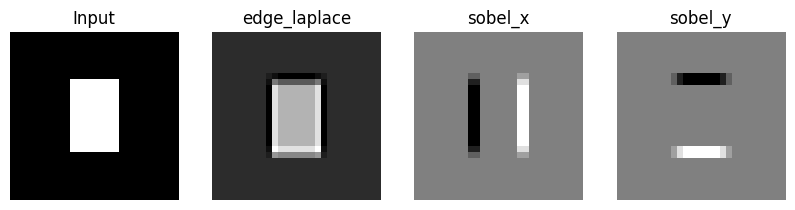

In [26]:
import scipy.signal as sig
plt.figure(figsize=(10, 3))
plt.subplot(1, 4, 1); plt.imshow(img, cmap='gray'); plt.title('Input'); plt.axis('off')
for i, (k, f) in enumerate(filters.items()):
    out = sig.convolve2d(img, f, mode='same', boundary='fill', fillvalue=0)
    plt.subplot(1, 4, i + 2); plt.imshow(out, cmap='gray', vmin=out.min(), vmax=out.max()); plt.title(k); plt.axis('off')
plt.show()


**Demonstration**

We will scale the learning capability that are learned by gradient: tiny networks trained to match

In [27]:
patches = np.random.randn(1000, 1, 7, 7).astype(np.float32)
true_filter = filters['sobel_x'].astype(np.float32)[np.newaxis, np.newaxis, :, :]

In [28]:
patches_t = torch.tensor(patches)
true_filters_t = torch.tensor(true_filter)

In [29]:
# compute targets
with torch.no_grad():
    targets = F.conv2d(patches_t, true_filters_t, padding=0)
    targets = targets[:, :, 2: -2, 2: -2]

In [30]:
# Model: single Conv Kernel to learn mapping
kernel = torch.randn((1, 1, 3, 3), requires_grad=True)
opt = torch.optim.SGD([kernel], lr=0.01)
for epoch in range(200):
    opt.zero_grad()
    out = F.conv2d(patches_t, kernel)
    
    # match center slice to targets shape
    out_c = out[:, :, 2:-2, 2:-2]
    loss  = ((out_c - targets) ** 2).mean()
    loss.backward()
    opt.step()
    if epoch % 50 == 0:
        print(epoch, loss.item())

0 25.415571212768555
50 3.4314401149749756
100 0.4752749502658844
150 0.06744920462369919


In [31]:
print('learned Kernel:', kernel.detach().numpy()[0,0])
print('True Kernel:', true_filter[0, 0])

learned Kernel: [[-0.9867935   0.010613    1.0125084 ]
 [-1.9438083  -0.04213881  1.9464886 ]
 [-1.0260944  -0.02153457  0.96873707]]
True Kernel: [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]


### 4. CNN features Extracted

`We will be using CNN Extracted dataset to classify (using SVM) between Features being learnt`

In [32]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [33]:
digits = datasets.load_digits()
images = digits.images
labels = digits.target

In [34]:
# Extract simple conv features: energy after applying filters

def extract_conv_features(images, filters):
    feats = []
    for img in images:
        fs = []
        for f in filters:
            out = sig.convolve2d(img, f, mode='same')
            fs.append(np.sum(np.abs(out)))
        feats.append(fs)
    return np.array(feats)

In [35]:
conv_filters = [filters['edge_laplace'], filters['sobel_x']]
features = extract_conv_features(images, conv_filters)
scaler = StandardScaler()
features_s = scaler.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(features_s, labels, test_size=0.3, random_state=0)
clf = SVC(kernel='rbf', gamma='scale')
clf.fit(X_train, y_train)
print('SVM accuracy on conv features:', accuracy_score(y_test, clf.predict(X_test)))

SVM accuracy on conv features: 0.26296296296296295


**4.1 Kernels: Intuition, examples and visualization**

In [38]:
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel
from sklearn.datasets import make_moons

In [37]:
a = np.array([[1.0, 2.0]])
b = np.array([[2.0, 1.0]])

print('linear', linear_kernel(a, b))
print('poly degree', polynomial_kernel(a, b, degree=2))
print('bell curve', rbf_kernel(a, b, gamma=0.5))

linear [[4.]]
poly degree [[9.]]
bell curve [[0.36787944]]


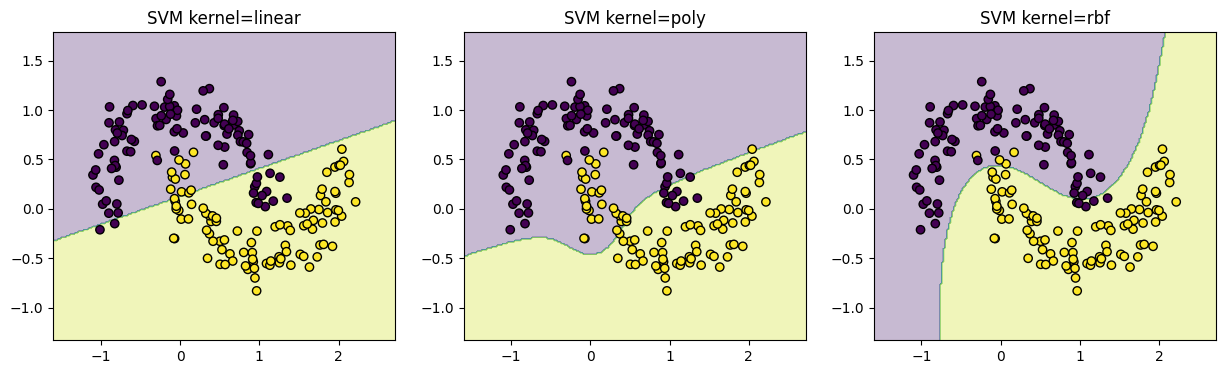

In [43]:
# visualization descision boundaries for different kernels on loaded dataset

Xk, yk = make_moons(n_samples=200, noise=0.15, random_state=1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
kernel_list = ['linear', 'poly', 'rbf']

for ax,k in zip(axes,kernel_list):
    model = SVC(kernel=k, degree=3, gamma='auto').fit(Xk, yk)
    xx, yy = np.meshgrid(np.linspace(Xk[:,0].min()-0.5, Xk[:,0].max()+0.5, 200),
    np.linspace(Xk[:,1].min()-0.5, Xk[:,1].max()+0.5, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(Xk[:,0], Xk[:,1], c=yk, edgecolors='k')
    ax.set_title(f'SVM kernel={k}')
plt.show()

### 5. Hopfield Networks (associative memory)
**We'll implement a binary Hopfield network (synchronous update) and store a few patches of pattern**

In [44]:
def hopfield_weights(patterns):
    # set of patterns from [-1, +1]
    
    n = patterns[0].size
    W = np.zeros((n, n))
    for p in patterns:
        W += np.outer(p, p)
    W[np.diag_indices(n)] = 0
    return W / len(patterns)

In [45]:
def hopfield_recall(W, pattern, steps=10):
    s = pattern.copy()
    for _ in range(steps):
        s = np.sign(W @ s)
        s[s==0] = 1
    return s

In [46]:
p1 = np.array([1,1,1,-1,-1,-1,1,1,1])
p2 = np.array([1,-1,1,-1,1,-1,1,-1,1])
W = hopfield_weights([p1,p2])
# noisy version of p1
p1_noisy = p1.copy()
p1_noisy[2] = -1
print('Original p1:', p1)
print('Noisy p1:', p1_noisy)
print('Recalled:', hopfield_recall(W, p1_noisy, steps=5))

Original p1: [ 1  1  1 -1 -1 -1  1  1  1]
Noisy p1: [ 1  1 -1 -1 -1 -1  1  1  1]
Recalled: [ 1.  1.  1. -1. -1. -1.  1.  1.  1.]


**How patterns are visually memorized**

Hopfield Network Pattern Recall:


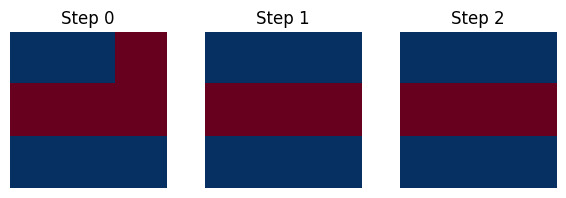

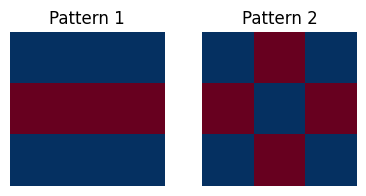

In [47]:
def visualize_hopfield_recall(W, pattern, steps=10):
    s = pattern.copy()
    states = [s.copy()]
    
    for _ in range(steps):
        s = np.sign(W @ s)
        s[s==0] = 1
        states.append(s.copy())
        if np.array_equal(states[-1], states[-2]):
            break
    
    # Visualize as 3x3 grids
    fig, axes = plt.subplots(1, len(states), figsize=(2*len(states), 2))
    for i, state in enumerate(states):
        grid = state.reshape(3, 3)
        axes[i].imshow(grid, cmap='RdBu', vmin=-1, vmax=1)
        axes[i].set_title(f'Step {i}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the recall process
print('Hopfield Network Pattern Recall:')
visualize_hopfield_recall(W, p1_noisy, steps=5)

# Show stored patterns
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(p1.reshape(3,3), cmap='RdBu', vmin=-1, vmax=1)
axes[0].set_title('Pattern 1')
axes[0].axis('off')
axes[1].imshow(p2.reshape(3,3), cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title('Pattern 2')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### 6. Hebbian Learning (Unsupervised weight update)
**We'll implement a simple Hebbian learning rule to update weights based on input patterns.**

In [49]:
eta = 0.1
n = 8
W_hebb = np.zeros((n,n))
# create binary patterns (±1)
pat = np.random.choice([-1,1], size=(n,))
for t in range(50):
    x = pat * (np.random.rand(n) > 0.1) * 2 - 1
    y = x.copy()
    W_hebb += eta * np.outer(y, x)


# test recall
probe = pat.copy()
probe[0] *= -1
recon = np.sign(W_hebb @ probe)
recon[recon==0]=1
print('pattern:', pat)
print('probe:', probe)
print('recon:', recon)

pattern: [-1 -1  1 -1  1  1 -1  1]
probe: [ 1 -1  1 -1  1  1 -1  1]
recon: [-1. -1.  1. -1.  1.  1. -1.  1.]
